### 1. Importing packages

In [ ]:
# data preprocessing
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

# machine learning
import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 2. Loading dataset

In [ ]:
start = (2020, 1, 2)  # 2020-01-02 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# loading Tesla, Inc. (TSLA) data from Yahoo Finance
df = pdr.DataReader('TSLA', 'yahoo', start_time, end_time)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [ ]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990
2020-12-30,696.599976,668.359985,672.00000,694.780029,42846000.0,694.780029
2020-12-31,718.719971,691.119995,699.98999,705.669983,49649900.0,705.669983


In [ ]:
X = df # using high price, low price, open price, close price, volume, and adj close price to predict adj close price
y = df.iloc[:, 5:6] # predicting adj close price

### 3. Scaling and converting data (without Sentiment Analysis results)

In [ ]:
MMS = MinMaxScaler()

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# input variables (6 variables)
X_train = X_data[:189, :] # training January - September data including high price, low price, open price, close price, volume and adj close data
X_test = X_data[189:, :] # verifying trained model, using October - December data as the test set

# output variables (adj close price)
y_train = y_data[:189, :]
y_test = y_data[189:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (189, 6) (189, 1)
Testing Set Shape (64, 6) (64, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([189, 1, 6]) torch.Size([189, 1])
Testing Shape torch.Size([64, 1, 6]) torch.Size([64, 1])


In [ ]:
device = torch.device('cpu')

### 4. Building LSTM model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes # number of classes
    self.num_layers = num_layers # number of layers
    self.input_size = input_size # input size
    self.hidden_size = hidden_size # hidden state
    self.seq_length = seq_length # sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # internal state   
    # propagating input through LSTM

    out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # decoding the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

### 5. Setting hyperparameters and training data

In [ ]:
num_epochs = 10000
learning_rate = 0.001
# learning rate controls how much to change the model in response to the estm. error each time the model weights are updated

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers
seq_length = 5 # to predict adj close price of sixth day using data of 5 previous days

num_classes = 1 # number of output classes
LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss() # mean-squared error for regression
# loss function measures how bad the model performs: high loss function -> low accuracy
optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate) # adam optimizer
# algorithms/methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses

In [ ]:
for epoch in range(num_epochs+1):
    outputs = LSTM_1.forward(X_train_tensors_final.to(device)) # forward pass
    optimizer.zero_grad() # calculating the gradient, manually setting to 0

    # obtaining the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() # calculating the loss of the loss function

    optimizer.step() # improving from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item())) 

Epoch: 0, Loss: 0.0727
Epoch: 100, Loss: 0.0271
Epoch: 200, Loss: 0.0212
Epoch: 300, Loss: 0.0174
Epoch: 400, Loss: 0.0121
Epoch: 500, Loss: 0.0044
Epoch: 600, Loss: 0.0005
Epoch: 700, Loss: 0.0002
Epoch: 800, Loss: 0.0001
Epoch: 900, Loss: 0.0001
Epoch: 1000, Loss: 0.0001
Epoch: 1100, Loss: 0.0001
Epoch: 1200, Loss: 0.0001
Epoch: 1300, Loss: 0.0001
Epoch: 1400, Loss: 0.0001
Epoch: 1500, Loss: 0.0001
Epoch: 1600, Loss: 0.0001
Epoch: 1700, Loss: 0.0001
Epoch: 1800, Loss: 0.0001
Epoch: 1900, Loss: 0.0001
Epoch: 2000, Loss: 0.0001
Epoch: 2100, Loss: 0.0001
Epoch: 2200, Loss: 0.0001
Epoch: 2300, Loss: 0.0001
Epoch: 2400, Loss: 0.0001
Epoch: 2500, Loss: 0.0001
Epoch: 2600, Loss: 0.0001
Epoch: 2700, Loss: 0.0001
Epoch: 2800, Loss: 0.0001
Epoch: 2900, Loss: 0.0001
Epoch: 3000, Loss: 0.0001
Epoch: 3100, Loss: 0.0001
Epoch: 3200, Loss: 0.0001
Epoch: 3300, Loss: 0.0001
Epoch: 3400, Loss: 0.0000
Epoch: 3500, Loss: 0.0000
Epoch: 3600, Loss: 0.0000
Epoch: 3700, Loss: 0.0000
Epoch: 3800, Loss: 0.000

In [ ]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

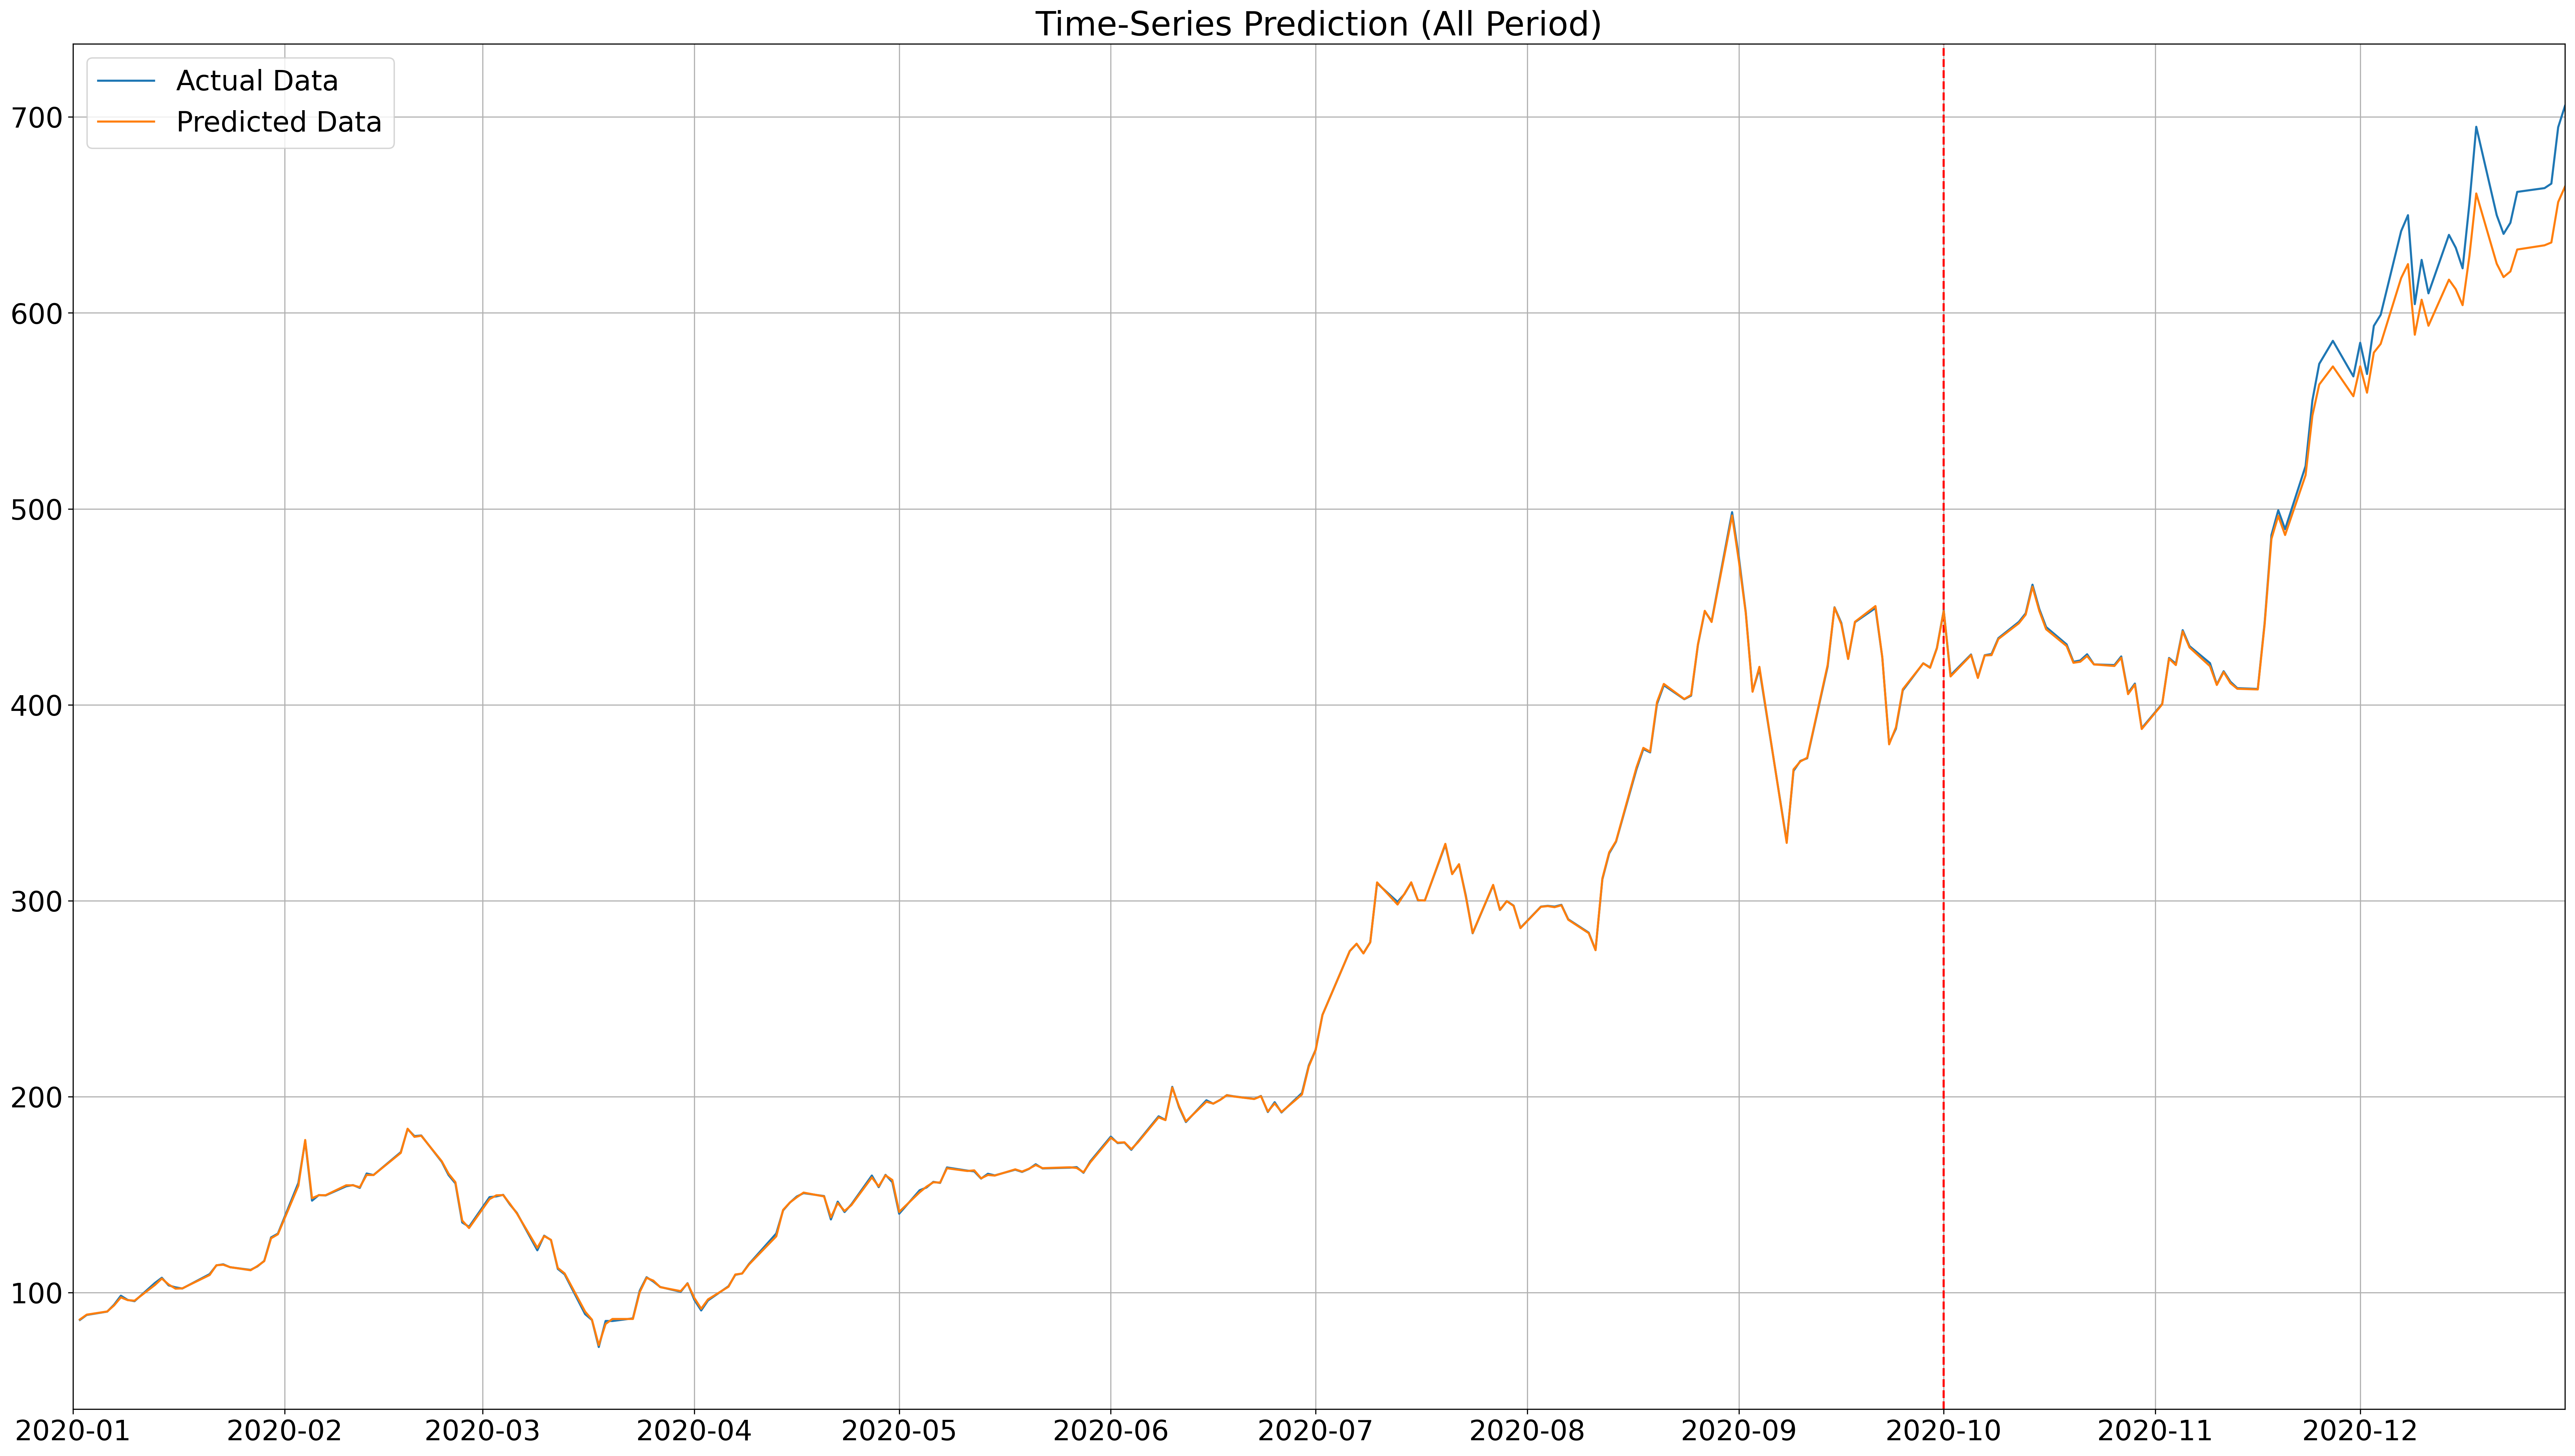

In [ ]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) # converting to tensors
df_y = Variable(torch.Tensor(y_data))
# reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = LSTM_1(df_X.to(device)) # forward pass
data_predict = train_predict.data.detach().cpu().numpy() # numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = MMS.inverse_transform(data_predict) # reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2020, 10, 1)
plt.axvline(x=test_line, c='r', linestyle='--') # size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plotting for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plotting for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.show()

In [ ]:
MSE = float(sum((dataY_plot - data_predict)*(dataY_plot - data_predict))/len(data_predict))
print('Mean Squared Error:', MSE)

Mean Squared Error: 55.4259147644043


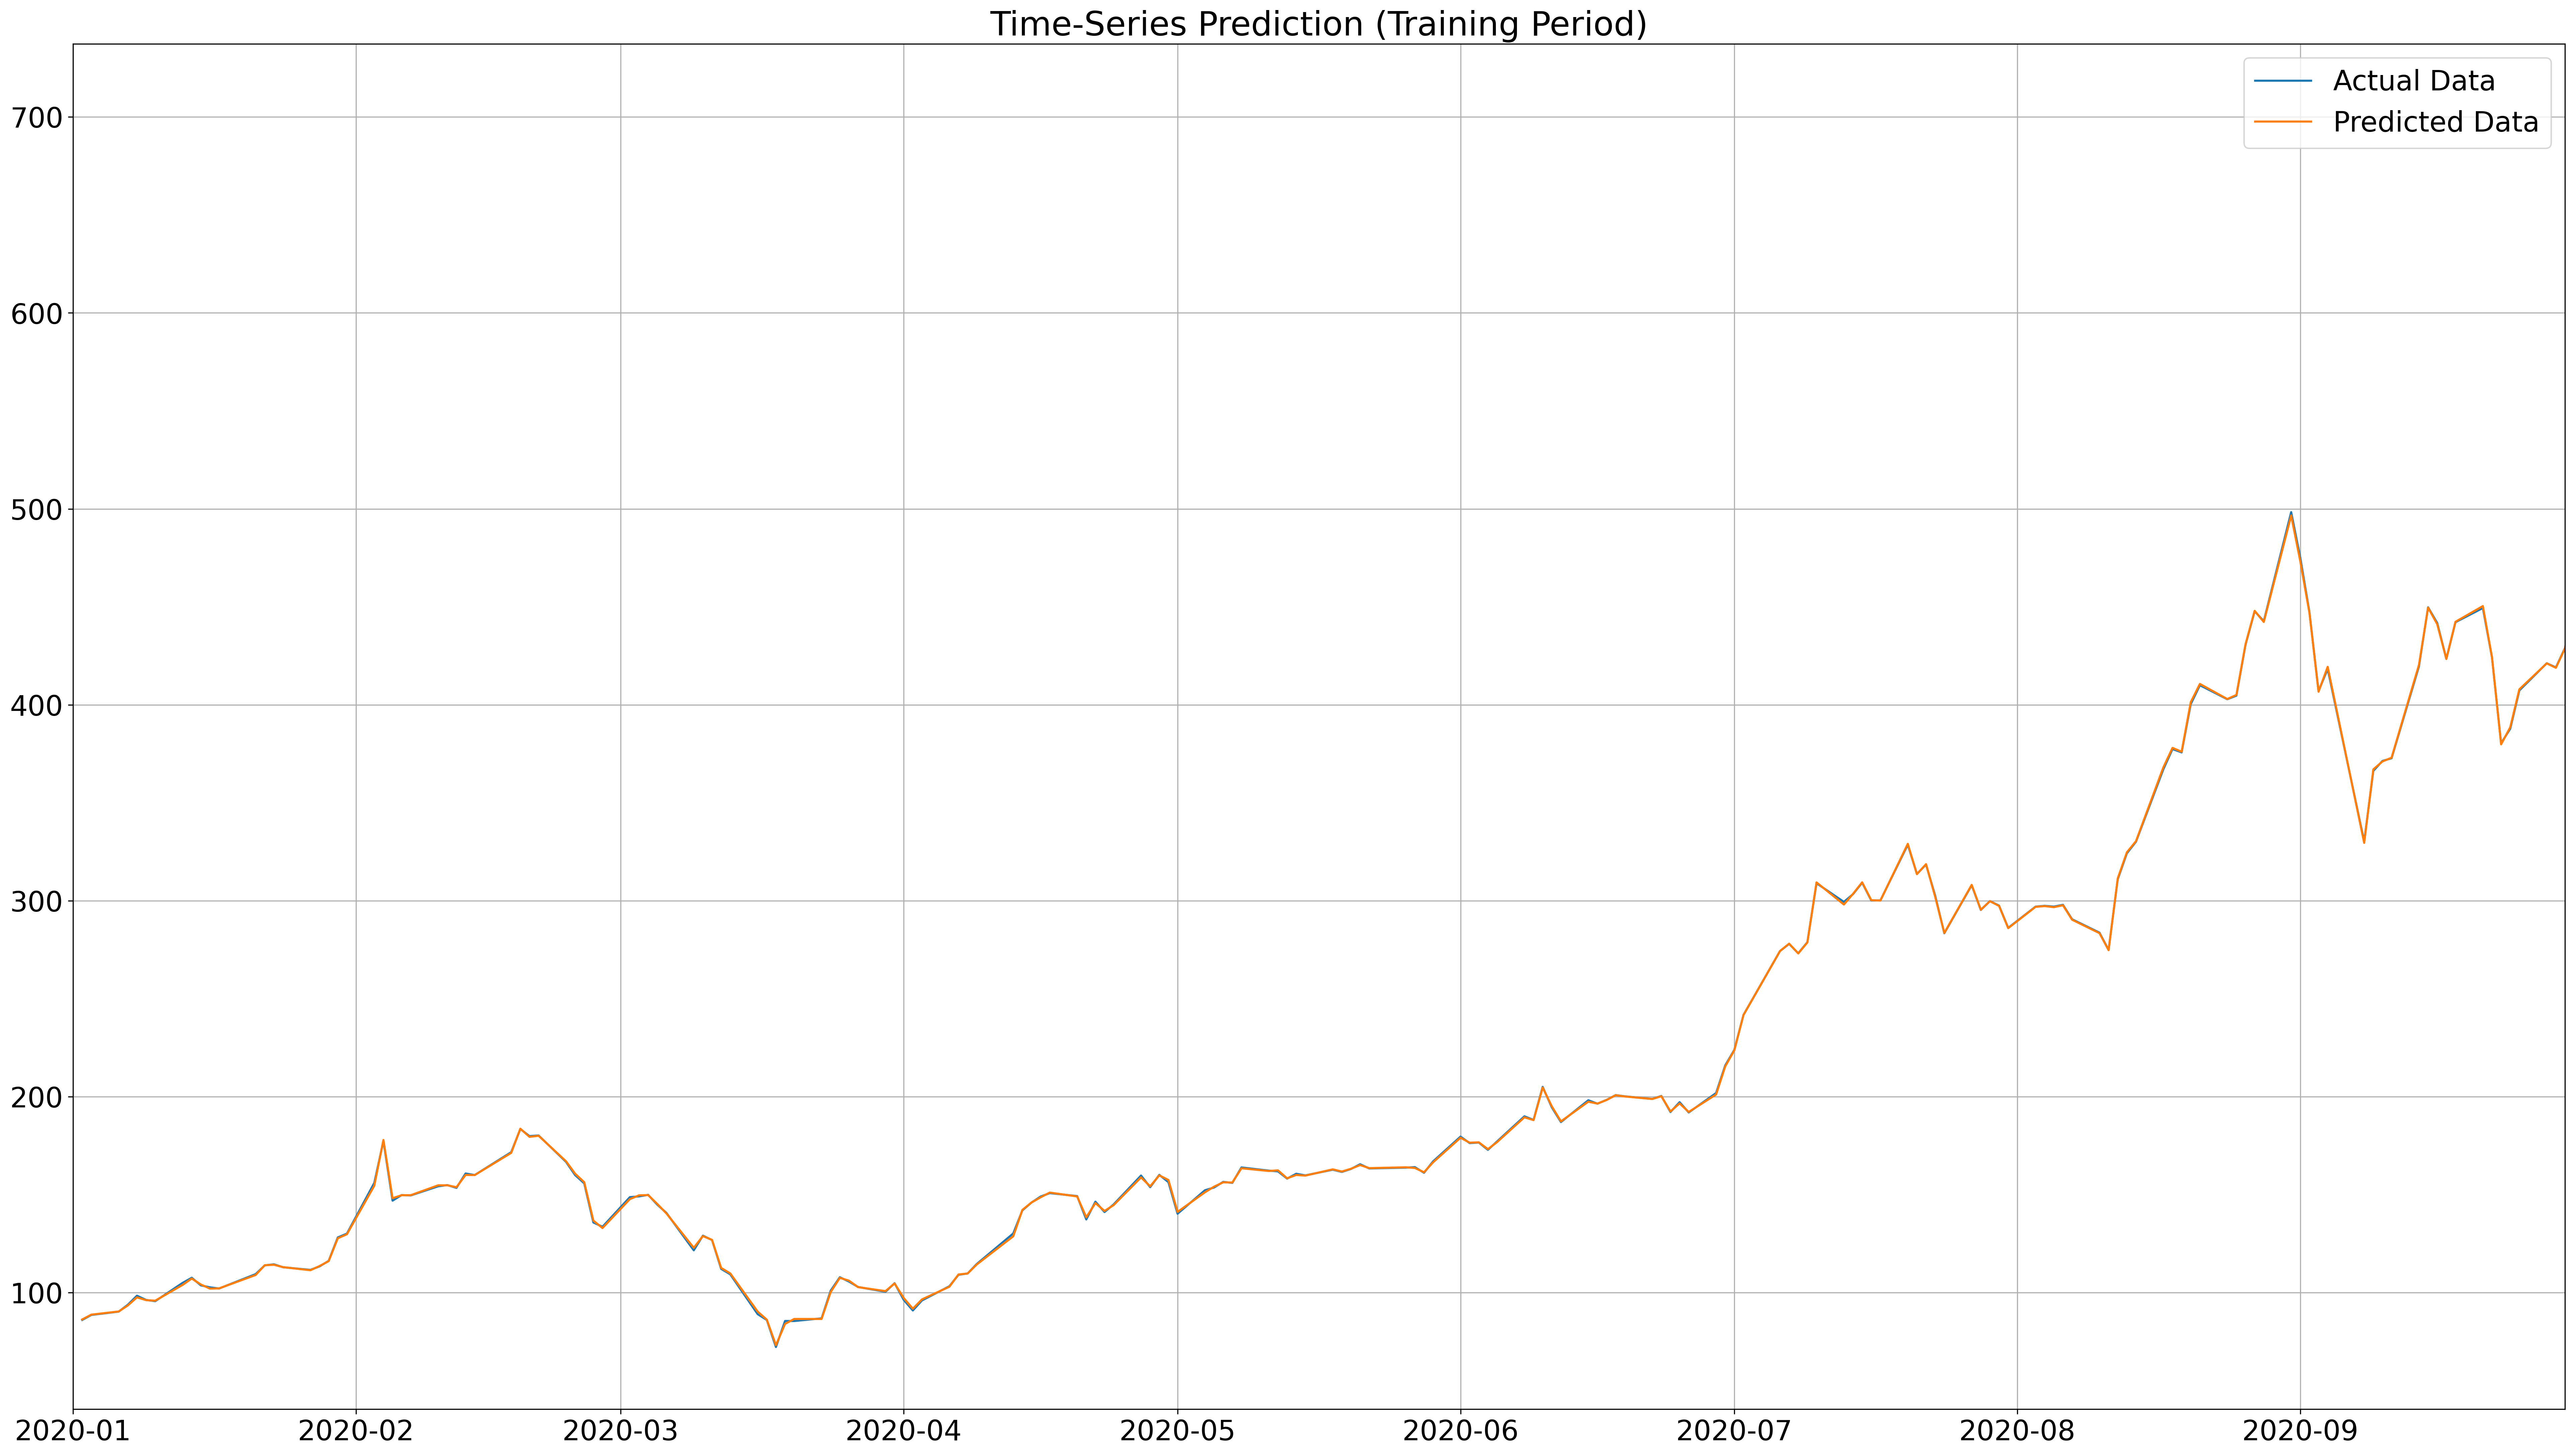

In [ ]:
plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 9, 30))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plotting for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plotting for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.show()

In [ ]:
MSE_train = float(sum((dataY_plot[0:189] - data_predict[0:189])*(dataY_plot[0:189] - data_predict[0:189]))/len(data_predict[0:189]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 0.30252882838249207


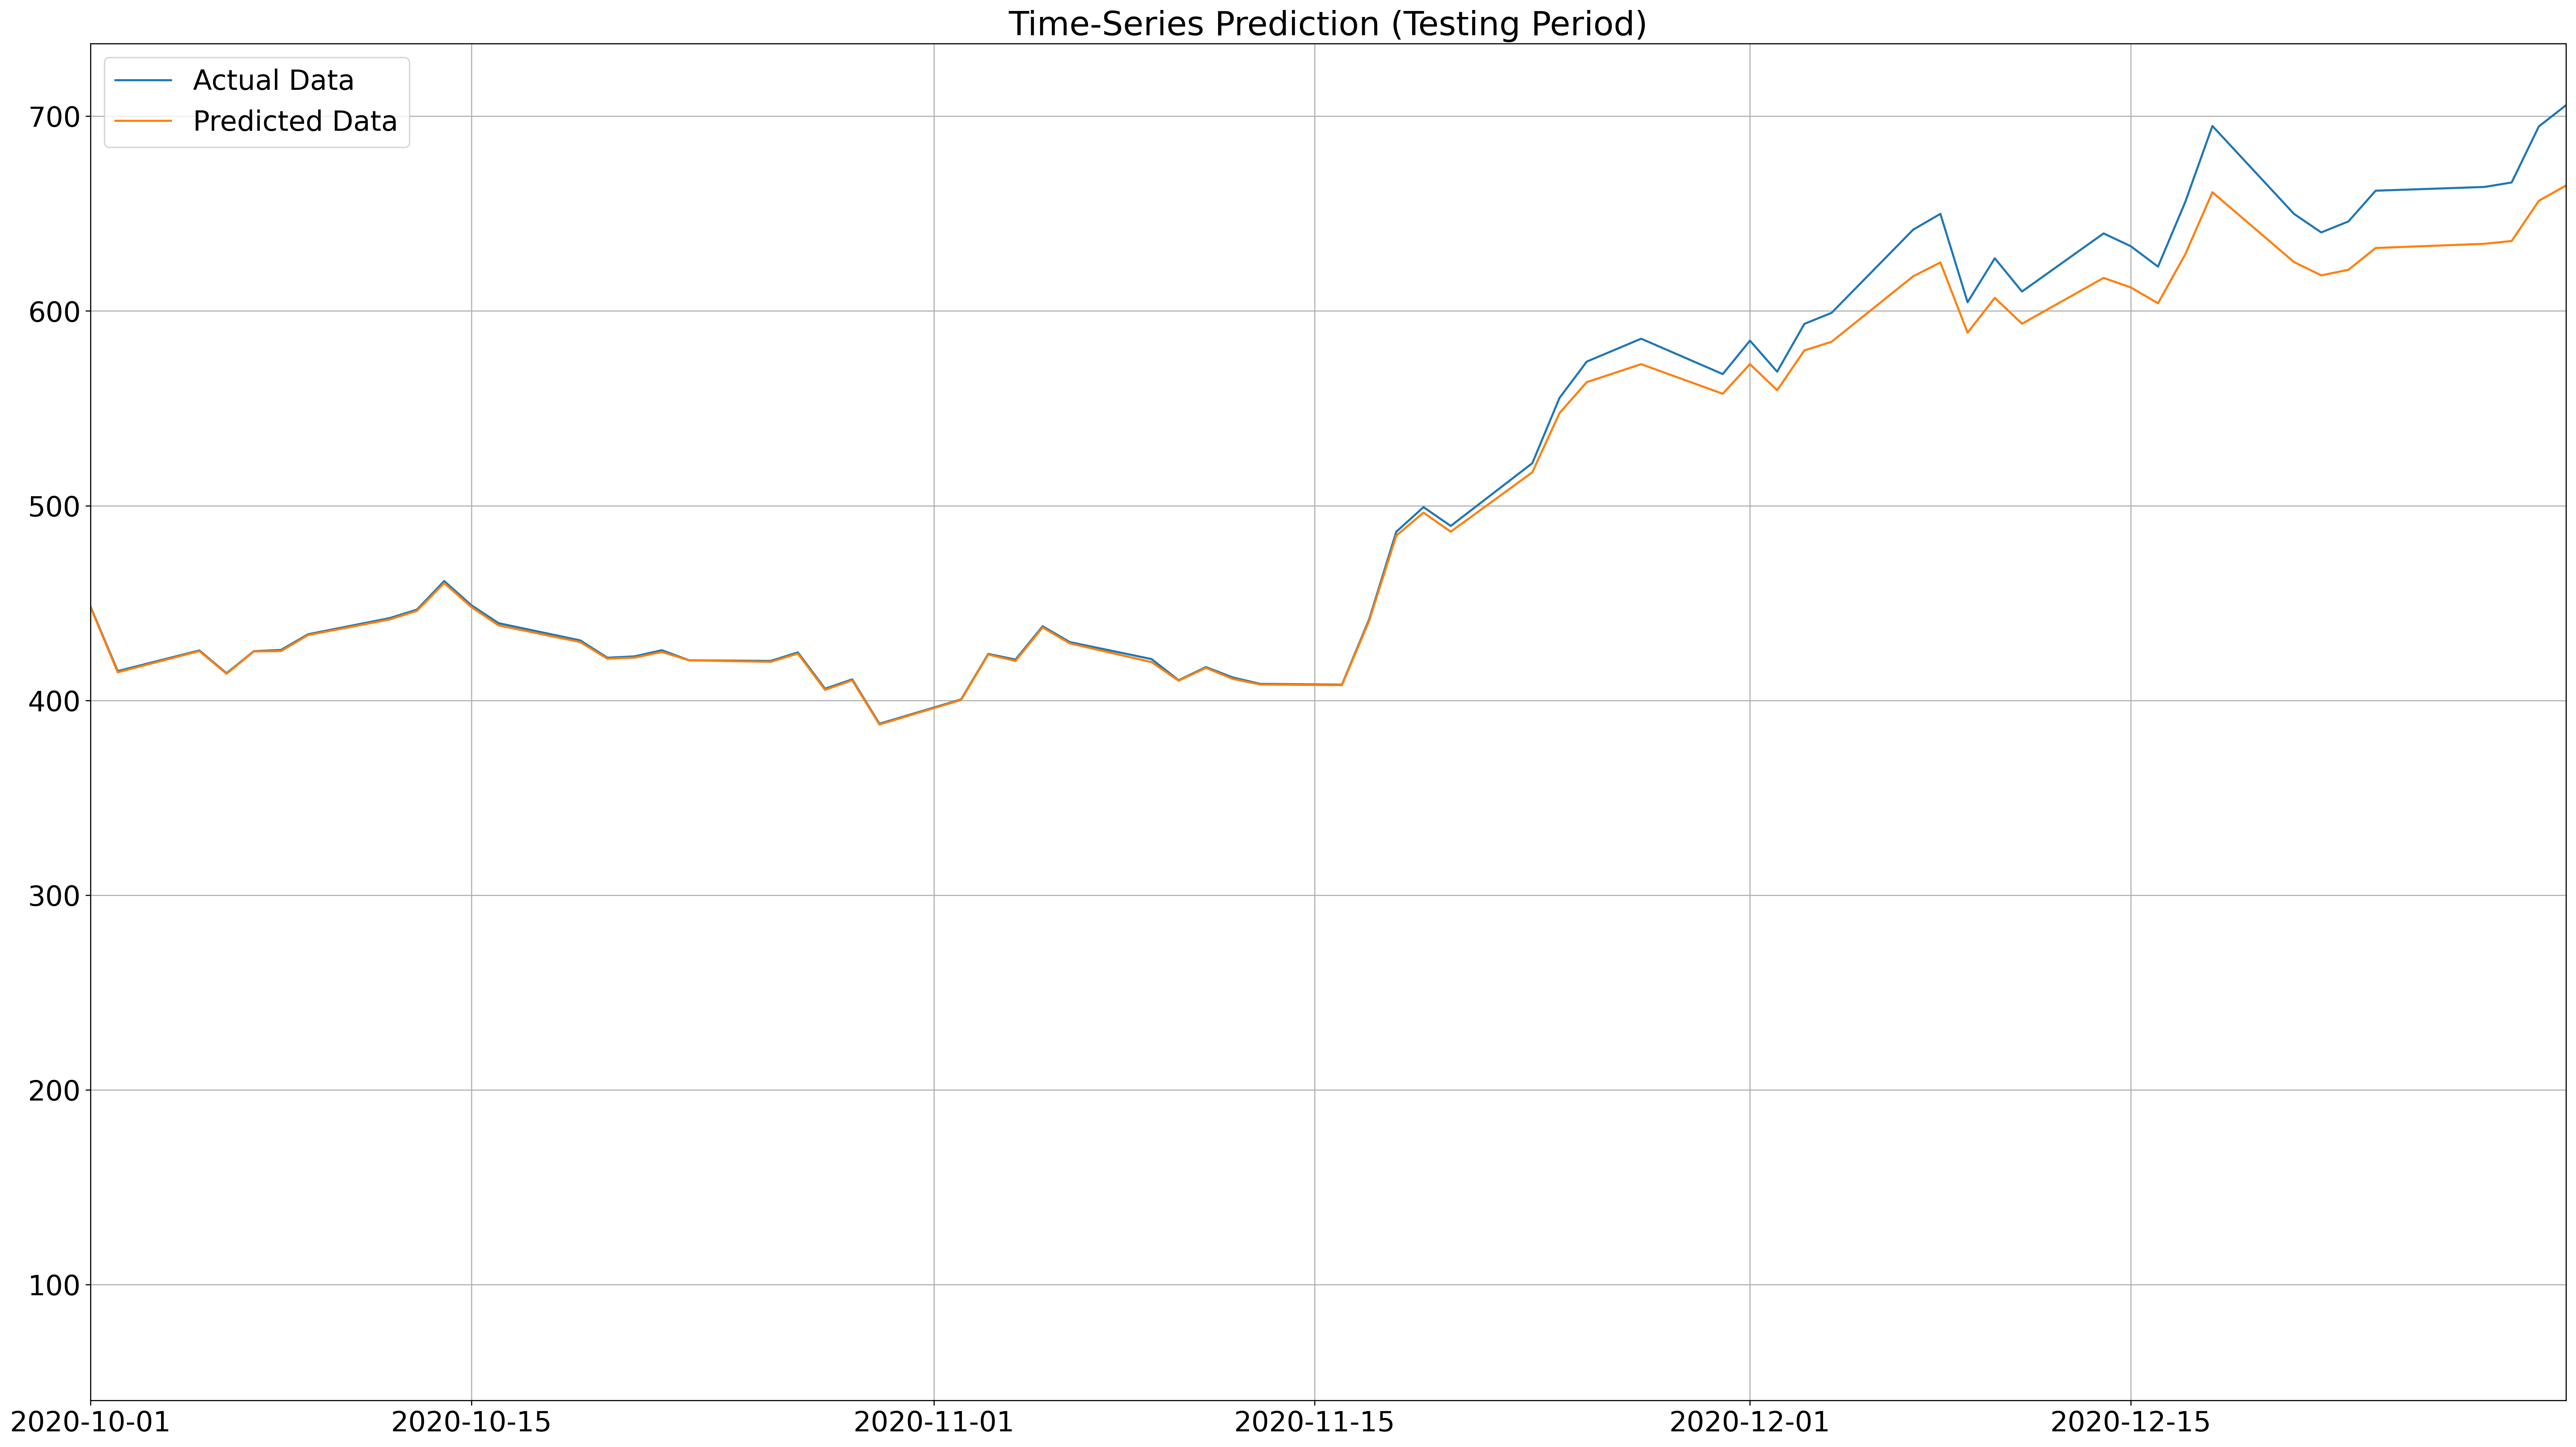

In [ ]:
plt.xlim(datetime.datetime(2020, 10, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plotting for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plotting for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.show()

In [ ]:
MSE_test = float(sum((dataY_plot[189:] - data_predict[189:])*(dataY_plot[189:] - data_predict[189:]))/len(data_predict[189:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 218.21217346191406
